# Mi primer EDA

## 1. Bloque de código para las bibliotecas que vamos a ir necesitando

In [1]:
import pandas as pd
import os
import json
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import Point

import folium
from branca.element import Element 

from itertools import combinations

# modelado
from sklearn.model_selection import train_test_split #división de datos del modelo ML
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# escalado
from sklearn.preprocessing import StandardScaler # implementar escalado
from sklearn.preprocessing import MinMaxScaler #implementar el escalado
from pickle import dump #dump: Función para guardar objetos en un archivo, en este caso el escalador.

# encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

#entrenamiento
from sklearn.linear_model import LinearRegression

## 2. Almacenamos la base de datos con la que vamos a trabajar y comprobamos que es correcta.

In [2]:
# Paso 1: Crear carpeta para almacenar datos en crudo
os.makedirs('./data/raw', exist_ok=True)

# Paso 2: Descargar y almacenar el archivo
url = "https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv"
file_path = './data/raw/AB_NYC_2019.csv'
df = pd.read_csv(url)

# Guardar una copia local en la carpeta indicada
df.to_csv(file_path, index=False)

# Paso 3: Cargar el conjunto de datos
# Verificamos las primeras filas para inspeccionar la estructura y composición del conjunto de datos
df = pd.read_csv(file_path)
df.head()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## 3. Conociendo el Data Set 

In [3]:
# Obtener las dimensiones
print("Filas , Columnas")
df.shape

Filas , Columnas


(48895, 16)

Obtenemos información sobre los tipos de datos y valores no nulos para más tarde  
 poder clasificarlos, modificarlos o anularnos en caso de no ser necesarios.

In [4]:
# Obtener información sobre tipos de datos y valores no nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

## 4. Trabajando los duplicados.

Usamos el método duplicated() para detectar duplicados en un DataFrame y
sum() para contar el número de duplicados.

In [5]:
duplicados = df.duplicated()
num_duplicados = duplicados.sum()
print(f"En este caso en contramos {num_duplicados} duplicados.")


En este caso en contramos 0 duplicados.


En caso de que haya duplicados los seleccionamos, eliminamos o modificamos a un valor que concuerde con la info del Data

In [6]:
#Para seleccionar duplicados:

#df_duplicados = df[duplicados]

#método drop_duplicates() para eliminar filas duplicadas. Se puede indicar el conjunto de atributos a considerar.

#df_sin_duplicados = df.drop_duplicates()

# ejemplo control de duplicados:

#df.duplicated().sum()
# sin considerar el id
#df.drop("Id", axis = 1).duplicated().sum()

## 5. Los Nulos

In [7]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Como podemos ver en last_reviews & en reviews_per_month hay bastantes nulos, es posible que prescindamos de estas columnas.

In [8]:
for column in df.columns:
    if df[column].isnull().sum() != 0:
        print("=======================================================")
        print(f"{column} ==> Missing Values : {df[column].isnull().sum()}, dtypes : {df[column].dtypes}")

name ==> Missing Values : 16, dtypes : object
host_name ==> Missing Values : 21, dtypes : object
last_review ==> Missing Values : 10052, dtypes : object
reviews_per_month ==> Missing Values : 10052, dtypes : float64


Rellenaremos los nulos de reviews_per_month con ceros para poder trabajar esta columna en caso de que sea necesaria y comprobamos.

In [9]:
df_new = df.copy()
df_new['reviews_per_month'] = df_new['reviews_per_month'].fillna(0)

df_new.isnull().sum()


id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
dtype: int64

## 6 Eliminando atributos no relevantes

In [10]:
df_new = df_new.drop(['id', 'name', 'host_id', 'host_name', 'last_review'], axis=1)
df_new.head()


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


Vamos a juntar en una sola columna la latitud y la longitud para tener las coordenadas en caso de que pueda ser util

In [11]:
# Combinar latitude y longitude en una columna 'coordinates' como tuple
df_new['coordinates'] = df_new.apply(lambda row: (row['latitude'], row['longitude']), axis=1)

# Eliminar las columnas originales si ya no son necesarias
df_new.drop(['latitude', 'longitude'], axis=1, inplace=True)

# Mostrar el resultado
df_new.head()

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,coordinates
0,Brooklyn,Kensington,Private room,149,1,9,0.21,6,365,"(40.64749, -73.97237)"
1,Manhattan,Midtown,Entire home/apt,225,1,45,0.38,2,355,"(40.75362, -73.98377)"
2,Manhattan,Harlem,Private room,150,3,0,0.00,1,365,"(40.80902, -73.9419)"
3,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,4.64,1,194,"(40.68514, -73.95976)"
4,Manhattan,East Harlem,Entire home/apt,80,10,9,0.10,1,0,"(40.79851, -73.94399)"


Volvemos a chequear los nulos de nuevo, ya tendríamos limpios los datos en este ámbito:

In [12]:
df_new.isnull().sum().sort_values(ascending = False)


neighbourhood_group               0
neighbourhood                     0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
coordinates                       0
dtype: int64

## 6. Variables Categóricas y numéricas - Limpiando el Data

Comprobamos de nuevo las clases de variables para poder luego seleccionarlas, dividirlas y eliminarlas en caso de no ser necesarias

In [13]:
df_new.dtypes

neighbourhood_group                object
neighbourhood                      object
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
coordinates                        object
dtype: object

In [14]:
# Identificar las variables numéricas
variables_numericas = df_new._get_numeric_data().columns
print("Las variables numéricas son:")
for var in variables_numericas:
    print(f" - {var}")

# Identificar las variables categóricas
variables_categoricas = set(df_new.columns) - set(variables_numericas)
print("\nLas variables categóricas son:")
for var in variables_categoricas:
    print(f" - {var}")


Las variables numéricas son:
 - price
 - minimum_nights
 - number_of_reviews
 - reviews_per_month
 - calculated_host_listings_count
 - availability_365

Las variables categóricas son:
 - room_type
 - neighbourhood_group
 - coordinates
 - neighbourhood


## 7 Análisis de las variables categóricas
-Empezaremos con un conteo

In [15]:
df_new.neighbourhood.value_counts()

neighbourhood
Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
                      ... 
Richmondtown             1
Fort Wadsworth           1
New Dorp                 1
Rossville                1
Willowbrook              1
Name: count, Length: 221, dtype: int64

In [16]:
df_new.room_type.value_counts()

room_type
Entire home/apt    25409
Private room       22326
Shared room         1160
Name: count, dtype: int64

In [17]:
df_new.neighbourhood_group.value_counts()

neighbourhood_group
Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: count, dtype: int64

In [18]:
df_new.coordinates.value_counts()

coordinates
(40.71232, -73.9422)     3
(40.75584, -73.99559)    2
(40.75888, -73.99077)    2
(40.76914, -73.98757)    2
(40.74882, -73.97788)    2
                        ..
(40.69832, -73.92622)    1
(40.72554, -73.98245)    1
(40.76089, -73.99879)    1
(40.70883, -74.00764)    1
(40.72778, -73.97825)    1
Name: count, Length: 48871, dtype: int64

Analizando si necesitamos las coordenadas para trabajar:

In [19]:


# Calcular el precio promedio total
average_price_total = df_new['price'].mean()

# Calcular el precio promedio por coordenada
price_by_coordinates = df_new.groupby('coordinates')['price'].mean()

# Crear un mapa centrado en Nueva York
ny_map = folium.Map(location=[40.7128, -74.0060], zoom_start=10)

# Función para asignar colores según el precio promedio
def color_for_price(price):
    if price < 100:
        return 'green'
    elif price < 300:
        return 'orange'
    else:
        return 'red'

# Agregar marcadores para las 500 coordenadas más frecuentes (según precio promedio)
for coord, avg_price in price_by_coordinates.head(500).items():
    folium.CircleMarker(
        location=[coord[0], coord[1]],  # Coordenadas (lat, long)
        radius=avg_price / 50,  # Ajustar el divisor para reducir el tamaño del marcador
        color=color_for_price(avg_price),  # Color del borde según el precio
        fill=True,
        fill_color=color_for_price(avg_price),  # Color de relleno
        fill_opacity=0.6,
        tooltip=f"<b>Coordenadas:</b> {coord}<br><b>Precio Promedio:</b> ${avg_price:.2f}"
    ).add_to(ny_map)

# Crear una leyenda manual en HTML con el precio promedio global
legend_html = f"""
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 250px;
    height: 150px;
    background-color: white;
    border:2px solid grey;
    z-index:9999;
    font-size:14px;
    padding: 10px;
    border-radius: 10px;">
    <b>Rango de Precios</b><br>
    <i style="background:green; width: 10px; height: 10px; float:left; margin-right: 10px; border-radius: 50%;"></i> Menor a $100<br>
    <i style="background:orange; width: 10px; height: 10px; float:left; margin-right: 10px; border-radius: 50%;"></i> $100 a $300<br>
    <i style="background:red; width: 10px; height: 10px; float:left; margin-right: 10px; border-radius: 50%;"></i> Mayor a $300<br>
    <br>
    <b>Precio Promedio Global:</b> ${average_price_total:.2f}
</div>
"""

# Agregar la leyenda al mapa
ny_map.get_root().html.add_child(Element(legend_html))

# Mostrar el mapa interactivo
ny_map


Visualización de la Distribución de Precios:

-Los círculos verdes indican áreas con precios promedio bajos (menores a $100).  
-Los círculos naranjas representan zonas con precios promedio moderados ($100 a $300).  
-Los círculos rojos muestran ubicaciones con precios promedio altos (mayores a $300).  
  
Los círculos rojos más grandes están concentrados en áreas urbanas densas, como Manhattan, lo que refleja una mayor demanda y precios más altos. Aún así podremos encontrar ofertas con precios precios más moderados en casi todas las zonas.  

Teniendo en cuenta que ya contamos con neighbourhood y neighbourhood_group, la extensa lista de coordenadas y que no nos vamos a meter en el análisis de los puntos de interés turístico y la distancia de los airbnb con ellos vamos a prescindir de esta columna para seguir con el EDA. 


In [20]:
df_new = df_new.drop(['coordinates'], axis=1)
df_new.head()

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,Private room,150,3,0,0.00,1,365
3,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,Entire home/apt,80,10,9,0.10,1,0


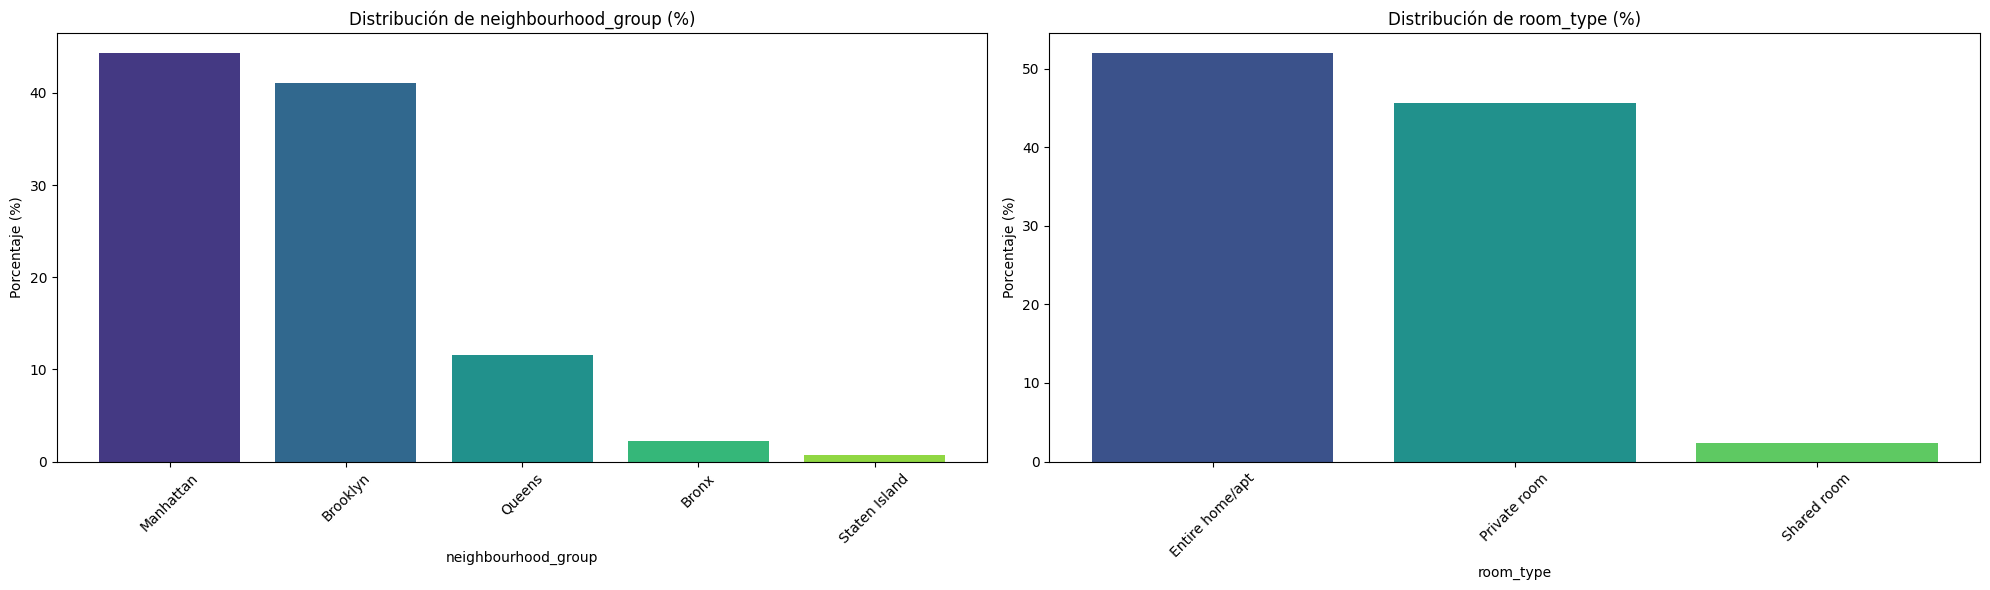

In [21]:

categoricas_analisis_1 = ['neighbourhood_group', 'room_type']

# Crear una cuadrícula de gráficos
fig, axes = plt.subplots(nrows=1, ncols=len(categoricas_analisis_1), figsize=(20, 6))

# Iterar por cada variable categórica y graficar con porcentajes
for i, col in enumerate(categoricas_analisis_1):
    # Calcular el porcentaje
    value_counts = df_new[col].value_counts(normalize=True) * 100
    
    # Crear un gráfico de barras con porcentajes
    axes[i].bar(value_counts.index, value_counts.values, color=sns.color_palette("viridis", len(value_counts)))
    
    # Configuración del gráfico
    axes[i].set_title(f'Distribución de {col} (%)')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Porcentaje (%)')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

En los gráficos de arriba podemos ver la cantidad de alojamientos que encontramos en cada agrupación de barrios y la cantidad de tipos de apartamentos / habitación en alquiler. 
Sobresaliendo Manhattan y Brooklyn en localización con más airbnb y los apartamentos completos seguidos de las habitaciones privadas como claras predominantes.

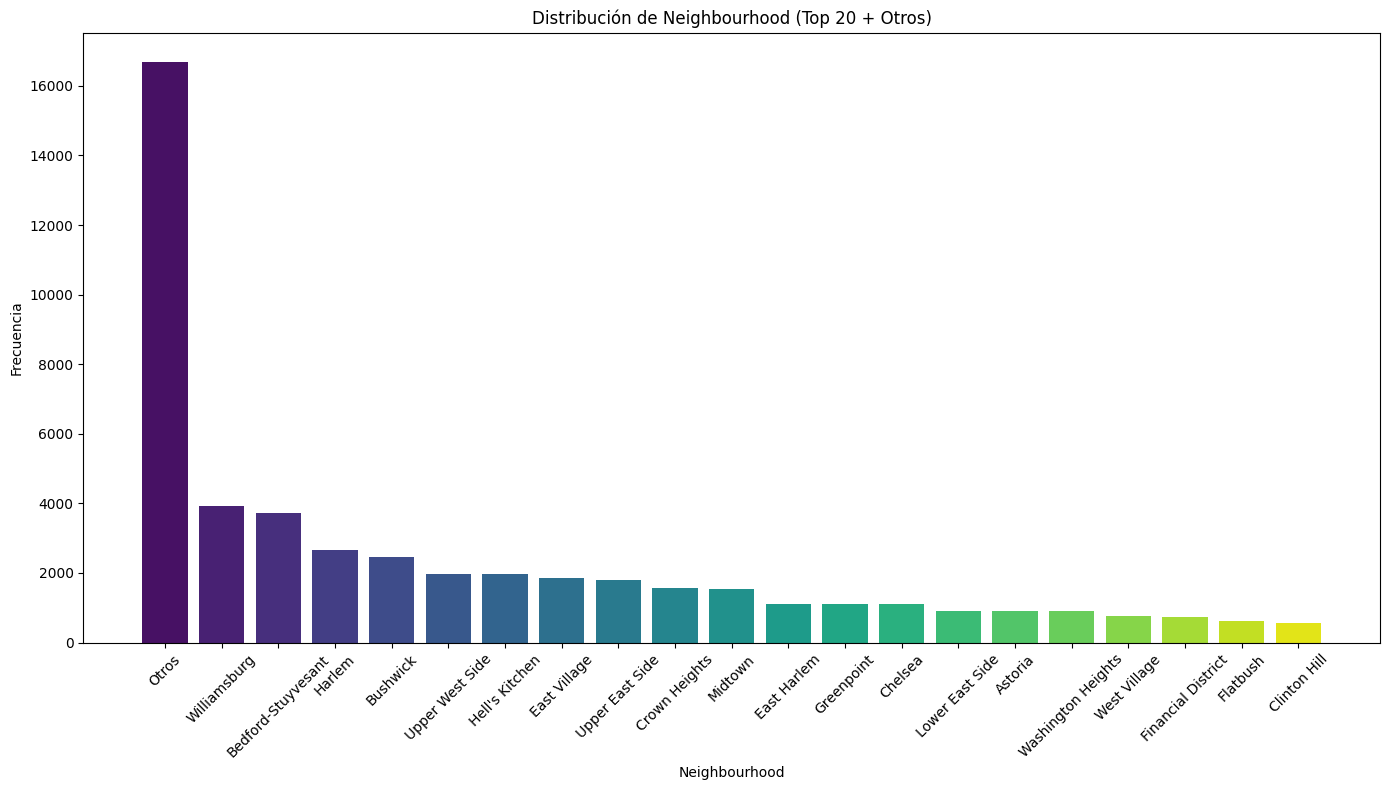

In [22]:
# Identificar los 20 barrios más representativos
top_20_neighbourhoods = df_new['neighbourhood'].value_counts().head(20).index

# Agrupar los barrios en una serie temporalmente para el gráfico
neighbourhood_counts = df_new['neighbourhood'].apply(
    lambda x: x if x in top_20_neighbourhoods else 'Otros'
).value_counts()

# Graficar la distribución de los barrios agrupados
plt.figure(figsize=(14, 8))
plt.bar(neighbourhood_counts.index, neighbourhood_counts.values, color=sns.color_palette('viridis', len(neighbourhood_counts)))
plt.title('Distribución de Neighbourhood (Top 20 + Otros)')
plt.xlabel('Neighbourhood')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Teniendo en cuenta la cantidad de barrios que hay y que ya los tenemos agrupados en la columna 'neighbourhood_group' he decidido prescindir de esta columna para facilitar el modelo de machine learning aunque renuncie a una preción mayor.

In [23]:
df_new = df_new.drop(['neighbourhood'], axis=1)
df_new.head()



,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Private room,149,1,9,0.21,6,365
1,Manhattan,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Private room,150,3,0,0.00,1,365
3,Brooklyn,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,Entire home/apt,80,10,9,0.10,1,0


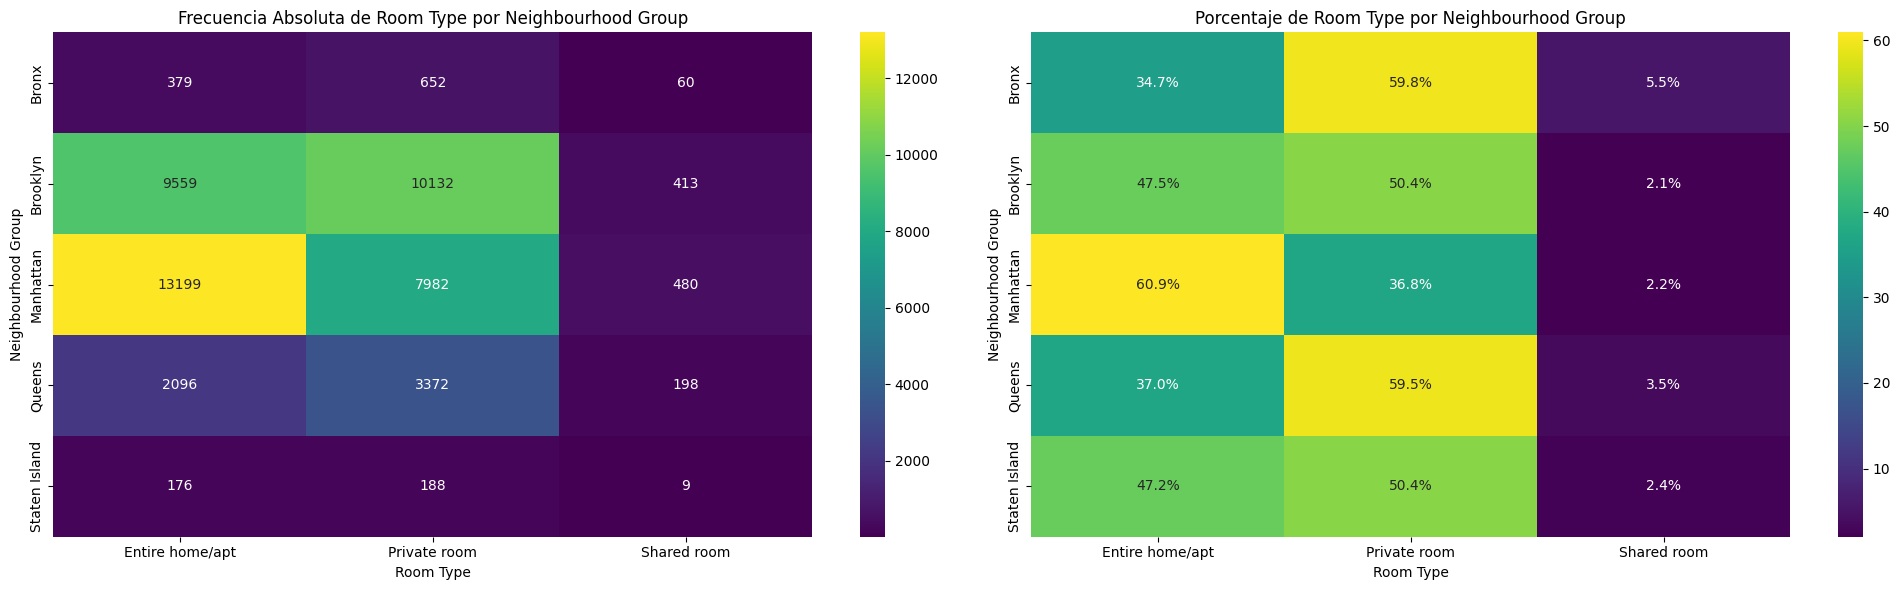

In [24]:

# Crear una tabla cruzada para frecuencias absolutas
heatmap_data = pd.crosstab(df_new['neighbourhood_group'], df_new['room_type'])

# Calcular porcentajes
heatmap_percent = heatmap_data.div(heatmap_data.sum(axis=1), axis=0) * 100

# Crear un DataFrame con los porcentajes formateados para anotaciones
annot_percent = heatmap_percent.round(1).astype(str) + '%'  # Formatear como texto con "%"

# Crear una cuadrícula para mostrar ambos gráficos
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Gráfico 1: Heatmap de Frecuencia Absoluta
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="viridis", cbar=True, ax=axes[0])
axes[0].set_title('Frecuencia Absoluta de Room Type por Neighbourhood Group')
axes[0].set_xlabel('Room Type')
axes[0].set_ylabel('Neighbourhood Group')

# Gráfico 2: Heatmap de Porcentajes
sns.heatmap(
    heatmap_percent, 
    annot=annot_percent,  # Usar el DataFrame de porcentajes formateados
    fmt='',  # Para texto personalizado en las anotaciones
    cmap="viridis", 
    cbar=True, 
    ax=axes[1]
)
axes[1].set_title('Porcentaje de Room Type por Neighbourhood Group')
axes[1].set_xlabel('Room Type')
axes[1].set_ylabel('Neighbourhood Group')

plt.tight_layout()
plt.show()


En los gráficos superiores que se representan tanto en porcentaje como en frecuencia podemos observar varias cosas relevantes para nuestro estudio: 
   
- En Manhattan predominan los apartamentos/casas completos con un 60,9% por ciento del mercado. Además de ser la que más propiedades tiene. Podemos sugerir que estamos hablando un enfoque mayor al mercado de lujo.
- En Brooklyn tenemos 50,4% de habitaciones privadas frente el 47,5% de establecimientos completos.   
- En Queens, con un número ya sigificativamente menor de propiedades, podemos ver como también predominan con el 59,5% la habitación privada. Aún siendo una diferencia no muy grande aún.  
- Por último, en el Bronx, con bastantes menos airbnbs sigue predominando la habitación privada. Será en el barrio donde más porcentaje de habitación compartida encontraremos, aún siendo pequeño (5,5%). Nos situamos en zonas con unos presupuestos más ajustados y menos turísticas.

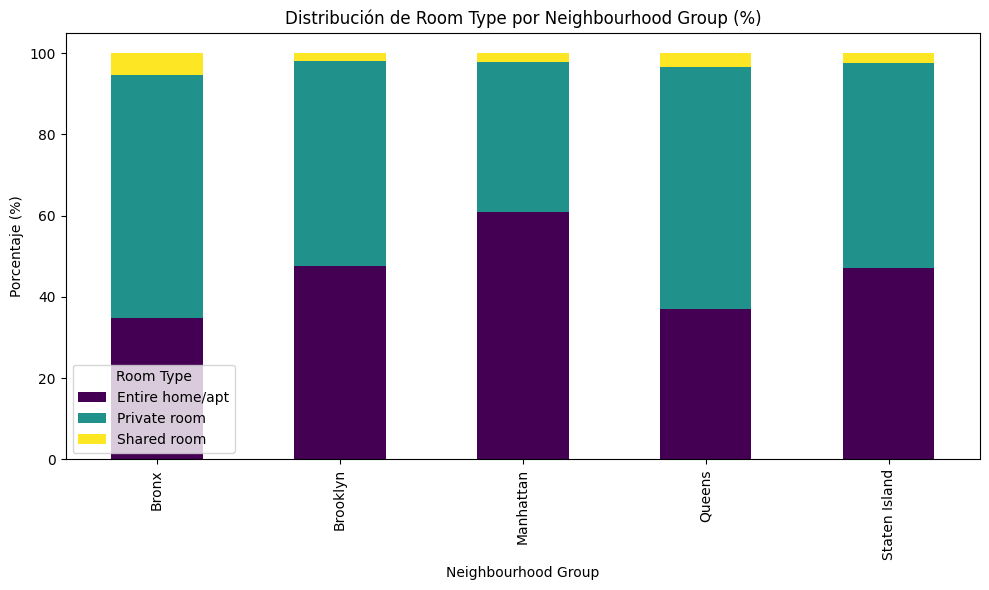

In [25]:
# Crear una tabla cruzada entre neighbourhood_group y room_type
cross_tab = pd.crosstab(df_new['neighbourhood_group'], df_new['room_type'], normalize='index') * 100

# Graficar la tabla cruzada como barras apiladas
cross_tab.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Distribución de Room Type por Neighbourhood Group (%)')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Porcentaje (%)')
plt.legend(title='Room Type')
plt.tight_layout()
plt.show()


## 8 Análisis de las variables numéricas
##### Hagamos un seguimiento de con qué variables nos hemos quedado por ahora

In [26]:
# Identificar las variables numéricas
variables_numericas = df_new._get_numeric_data().columns
print("Las variables numéricas son:")
for var in variables_numericas:
    print(f" - {var}")

# Identificar las variables categóricas
variables_categoricas = set(df_new.columns) - set(variables_numericas)
print("\nLas variables categóricas son:")
for var in variables_categoricas:
    print(f" - {var}")


Las variables numéricas son:
 - price
 - minimum_nights
 - number_of_reviews
 - reviews_per_month
 - calculated_host_listings_count
 - availability_365

Las variables categóricas son:
 - neighbourhood_group
 - room_type


Resumen estadístico y gráficos de frecuencia generales de las variables numéricas:

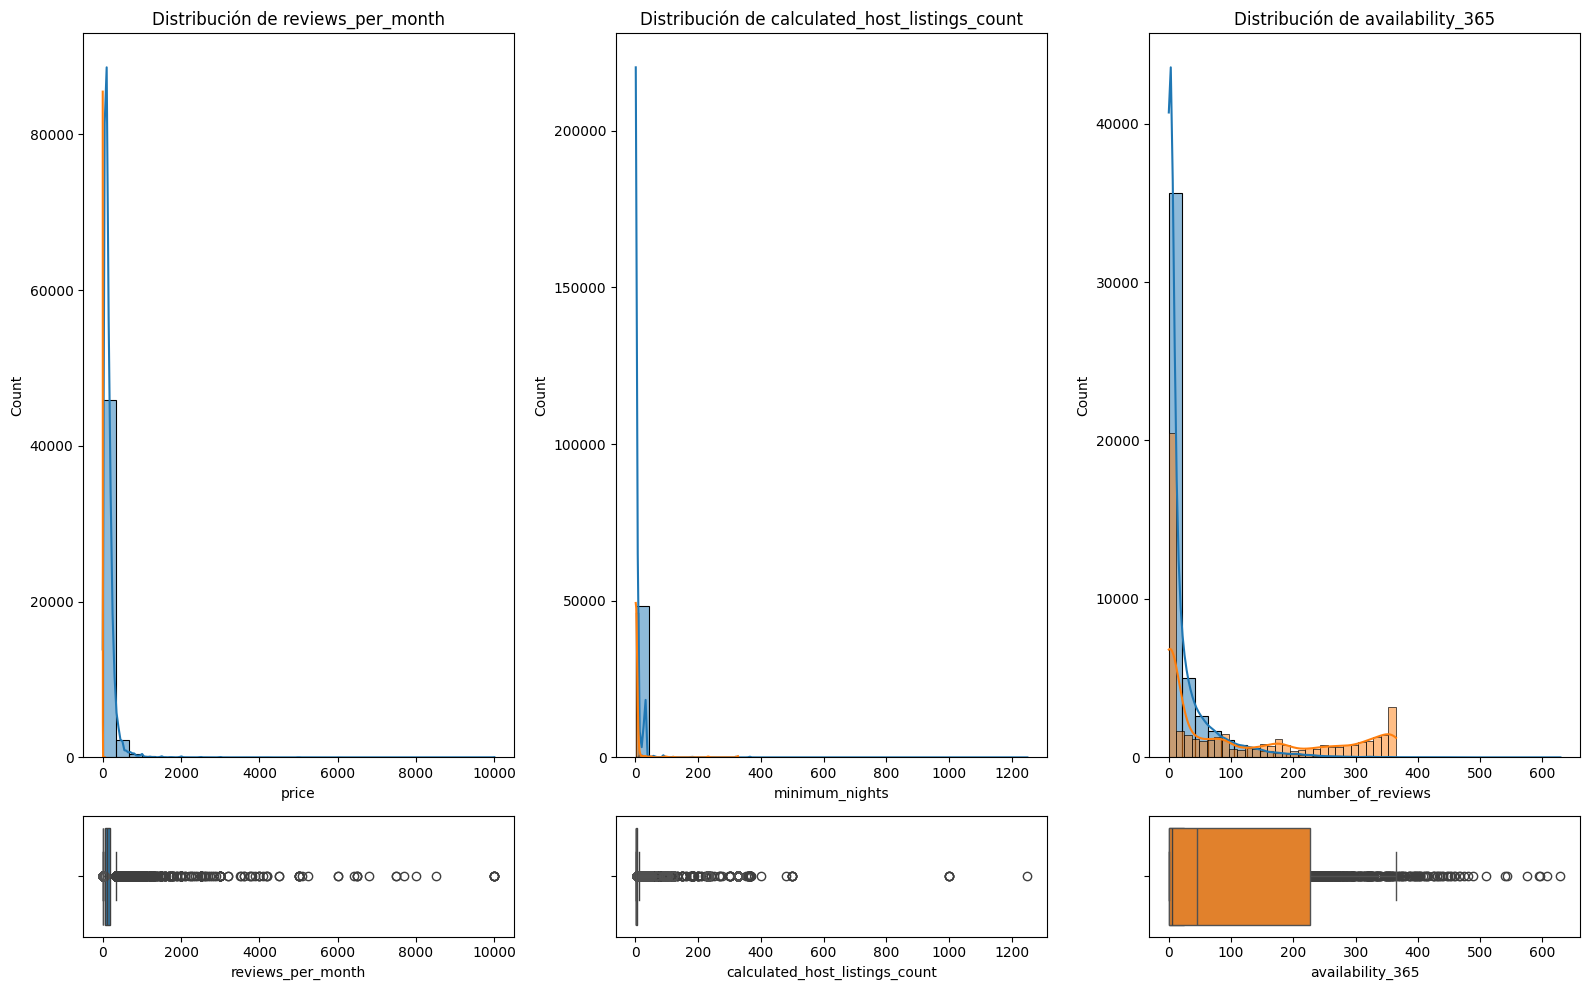

In [27]:
# Resumen estadístico general
#df_new.describe()


# Configuración de la cuadrícula: histogramas arriba y boxplots abajo
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10), gridspec_kw={'height_ratios': [6, 1]})

# Iterar sobre las variables numéricas
for i, col in enumerate(variables_numericas):
    row = 0  # Fila para el histograma
    col_index = i % 3  # Columna en la cuadrícula
    sns.histplot(data=df_new, x=col, kde=True, bins=30, ax=axes[row, col_index])  # Histograma
    axes[row, col_index].set_title(f'Distribución de {col}')

    row = 1  # Fila para el boxplot
    sns.boxplot(data=df_new, x=col, ax=axes[row, col_index])  # Boxplot
    axes[row, col_index].set_xlabel(col)

# Ajustar diseño para evitar solapamientos
plt.tight_layout()

# Mostrar los gráficos
plt.show()





- Precio: La mayoría de los precios están por debajo de aprox 200$, pero hay valores extremos muy altos.
- Mínimo de noches: La mayor parte de las estancias son cortas pero con los valores extremos no podemos visualizarlo bien.
- Número de reviews: La mayor parte tienen muy pocas reviews y unas pocas destacan. 
- Reseñas por mes: Muchas propiedades no tienen actividad, chequear las que tienen más para identificar patrones. Decido quedarme con el nº total de reviews y elimino esta columna.
- Propiedades por anfitrión: La mayor parte tiene una sola propiedad, omitiremos esta columna. No creo que sea significativa.
- Disponibilidad anual: Relacionar con precios.

Hay muchos outliers a trabajar. 


In [28]:
df_new = df_new.drop(['calculated_host_listings_count', 'reviews_per_month'], axis=1)

# Identificar las variables numéricas
variables_numericas = df_new._get_numeric_data().columns
print("Las variables numéricas son:")
for var in variables_numericas:
    print(f" - {var}")

# Identificar las variables categóricas
variables_categoricas = set(df_new.columns) - set(variables_numericas)
print("\nLas variables categóricas son:")
for var in variables_categoricas:
    print(f" - {var}")


Las variables numéricas son:
 - price
 - minimum_nights
 - number_of_reviews
 - availability_365

Las variables categóricas son:
 - neighbourhood_group
 - room_type


### Análisis numérico-numérico


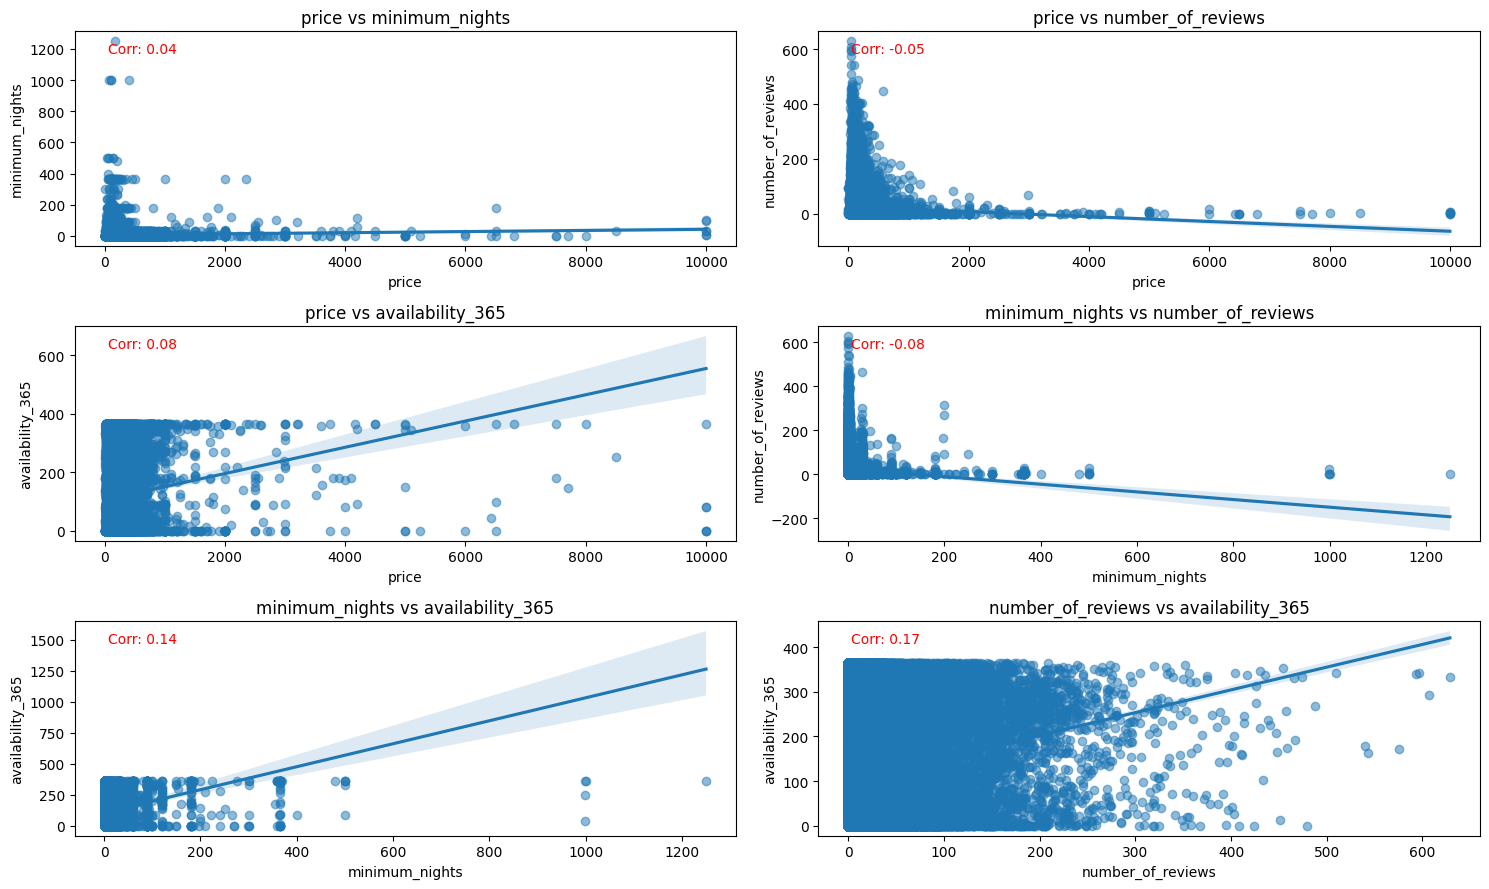

In [29]:
pairs = list(combinations(variables_numericas, 2))  # Generar todas las combinaciones de pares

# Determinar el tamaño dinámico de la cuadrícula
rows = len(pairs) // 2 + len(pairs) % 2
fig, axes = plt.subplots(rows, 2, figsize=(15, rows * 3))

for idx, (col1, col2) in enumerate(pairs):
    row, col = divmod(idx, 2)  # Calcular posición de la cuadrícula
    sns.regplot(ax=axes[row, col], data=df_new, x=col1, y=col2, scatter_kws={'alpha': 0.5})
    axes[row, col].set_title(f'{col1} vs {col2}')
    corr = df_new[[col1, col2]].corr().iloc[0, 1]
    axes[row, col].annotate(f"Corr: {corr:.2f}", xy=(0.05, 0.95), xycoords='axes fraction', 
                            fontsize=10, color='red', ha='left', va='top')

# Eliminar espacios vacíos si no se usan todas las subplots
if len(pairs) % 2 != 0:
    fig.delaxes(axes[-1, -1])  # Eliminar el último eje si no hay suficientes pares

plt.tight_layout()
plt.show()


Conclusiones:

- Precio y Noches Mínimas: Estos datos no tienen una relación clara, por lo que probablemente no sea necesario realizar más análisis. Nada significativa.
- Precio y nº de reviews: Tiene una corelación muy floja, se ven acumuladas en precios más bajo. No significativo.
- Precio y disponibilidad: Parece haber una relación muy débil donde las propiedades más disponibles tienen precios más altos. No significativo.
- Mínimo de noches y reviews: Relación débil. Propiedades con menos noches mínimas pueden tener más reseñas. No significativo.
- Mínimo de noches y disponibilidad: Parece que cuanto más aumentan las noches también la disponibilidad, aunque hay outliers. Relación debil.
- Número de Reseñas y Disponibilidad: Existe una correlación leve que sugiere que la disponibilidad influye en el número de reseñas, pero no de manera muy significativa.

Podemos ver que entre las variables numéricas las correlaciones son muy bajas. Tienen a tener poca relación entre si. Y podemos observar los outliers que trabajar.

## 9. Análisis multivariante
#### Tras analizar las características una a una, es momento de analizarlas en relación con la predictoria y con ellas mismas para sacar conclusiones más claras acerca de sus relaciones y tomar decisiones sobre su procesamiento

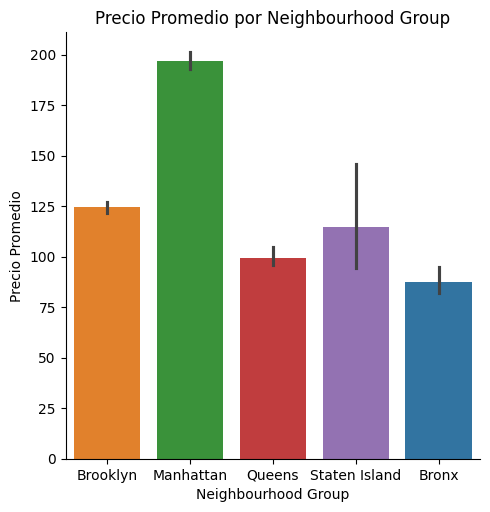

In [30]:
# Diccionario de colores personalizados
custom_palette = {
    'Bronx': '#1f77b4',
    'Brooklyn': '#ff7f0e',
    'Manhattan': '#2ca02c',
    'Queens': '#d62728',
    'Staten Island': '#9467bd'
}

sns.catplot(
    x='neighbourhood_group',
    y='price',
    data=df_new,
    kind='bar',
    hue='neighbourhood_group',
    palette=custom_palette
)

plt.title("Precio Promedio por Neighbourhood Group")
plt.xlabel("Neighbourhood Group")
plt.ylabel("Precio Promedio")
plt.show()


Hacemos este gráfico antes de factorizar para tener en cuenta que si que hay diferencias significativas y están relacionados los precios con los barrios

##### Factorizar las variables categóricas

In [31]:
# Reemplazar las variables categóricas con sus valores numéricos /
for col in variables_categoricas:
    df_new[col] = pd.factorize(df_new[col])[0]

# Verificar el resultado
df_new.head()

#NO ESTA PERO ES MEJOR HACER COPIA DE LAS VARIABLES FACTORIZADAS Y MANTENER LA ORIGINAL

# Crear copias factorizadas de las columnas categóricas mientras se preservan las originales
# for col in variables_categoricas:
#   df_new[f"{col}_factorized"] = pd.factorize(df_new[col])[0]




,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,availability_365
0,0,0,149,1,9,365
1,1,1,225,1,45,355
2,1,0,150,3,0,365
3,0,1,89,1,270,194
4,1,1,80,10,9,0



Categorías de 'neighbourhood_group' y sus valores numéricos:  
  0 -> Brooklyn  
  1 -> Manhattan  
  2 -> Queens  
  3 -> Staten Island  
  4 -> Bronx  

Categorías de 'room_type' y sus valores numéricos:  
  0 -> Private room  
  1 -> Entire home/apt  
  2 -> Shared room  


In [32]:
# Identificar las variables numéricas
variables_numericas = df_new._get_numeric_data().columns
print("Las variables numéricas son:")
for var in variables_numericas:
    print(f" - {var}")

# Identificar las variables categóricas
variables_categoricas = set(df_new.columns) - set(variables_numericas)
print("\nLas variables categóricas son:")
for var in variables_categoricas:
    print(f" - {var}")


Las variables numéricas son:
 - neighbourhood_group
 - room_type
 - price
 - minimum_nights
 - number_of_reviews
 - availability_365

Las variables categóricas son:


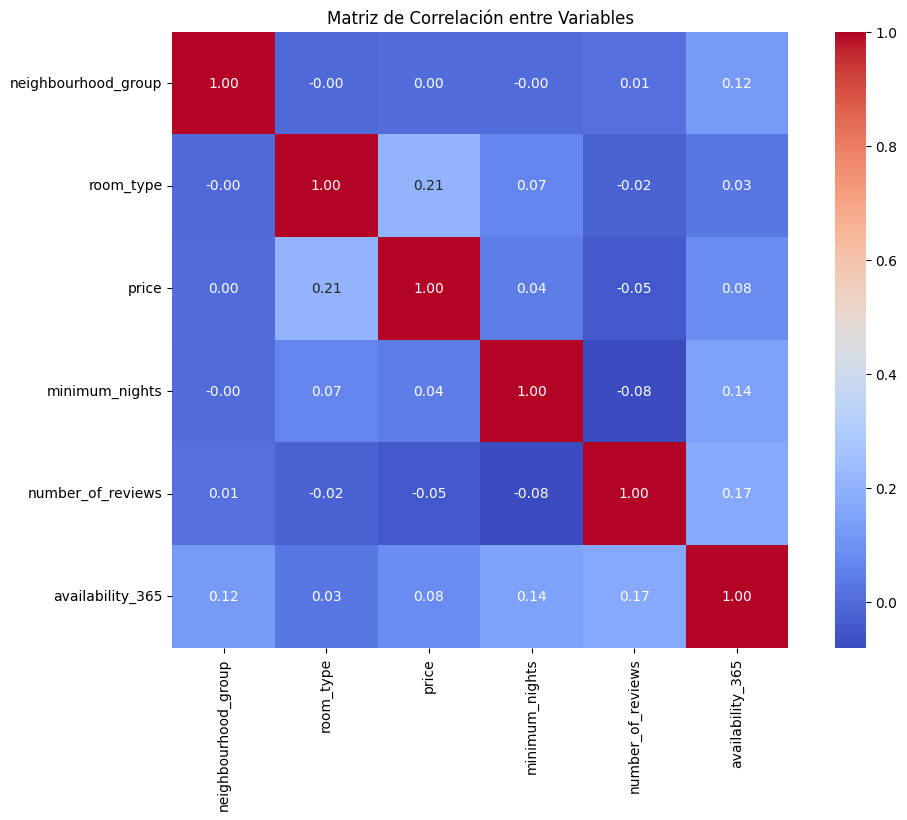

In [33]:
# Calcular la matriz de correlación entre todas las variables numéricas
correlation_matrix = df_new.corr()

# Graficar el heatmap para visualizar las correlaciones
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Matriz de Correlación entre Variables")
plt.show()


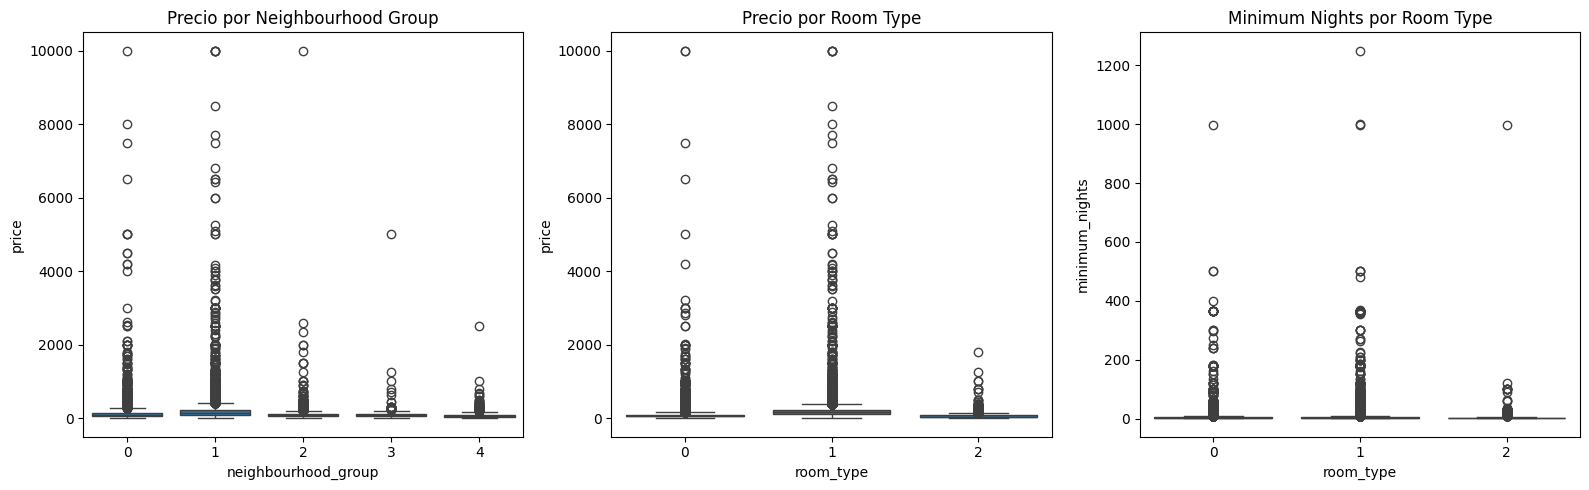

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

sns.boxplot(data=df_new, x='neighbourhood_group', y='price', ax=axes[0])
axes[0].set_title('Precio por Neighbourhood Group')

sns.boxplot(data=df_new, x='room_type', y='price', ax=axes[1])
axes[1].set_title('Precio por Room Type')

sns.boxplot(data=df_new, x='room_type', y='minimum_nights', ax=axes[2])
axes[2].set_title('Minimum Nights por Room Type')

plt.tight_layout()
plt.show()


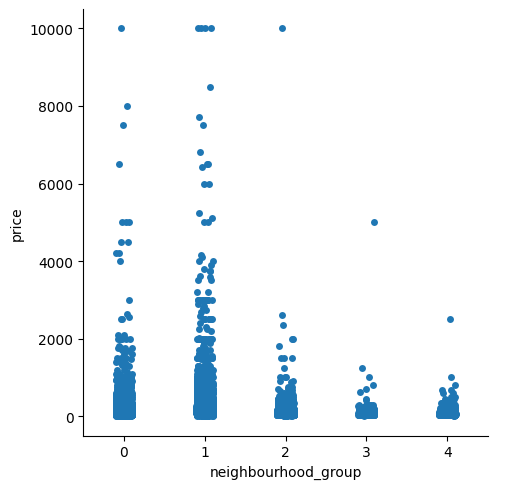

In [35]:
sns.catplot(x = 'neighbourhood_group', y = 'price', data = df_new)

/tmp/ipykernel_49516/1206514648.py:3: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(x = 'neighbourhood_group', y = 'price', data = df1, scale = 'count', linewidth = 0.3)


<Axes: xlabel='neighbourhood_group', ylabel='price'>

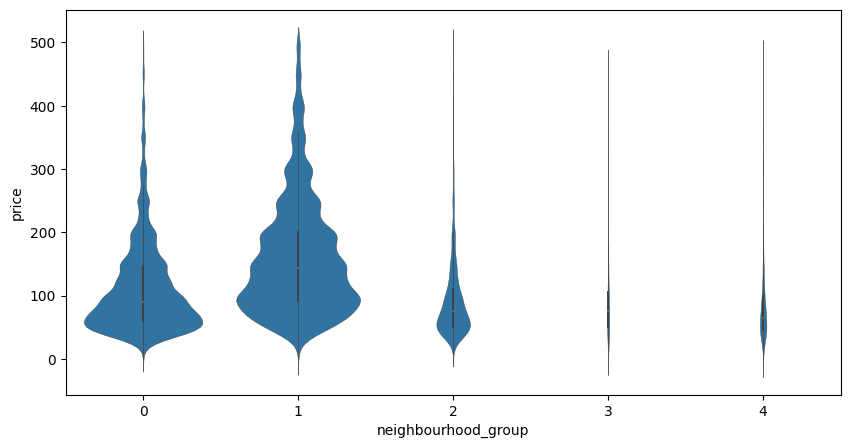

In [36]:
df1 =df_new[df_new['price']<500]
plt.figure(figsize = (10,5))
sns.violinplot(x = 'neighbourhood_group', y = 'price', data = df1, scale = 'count', linewidth = 0.3)

### Relaciones todos con todos

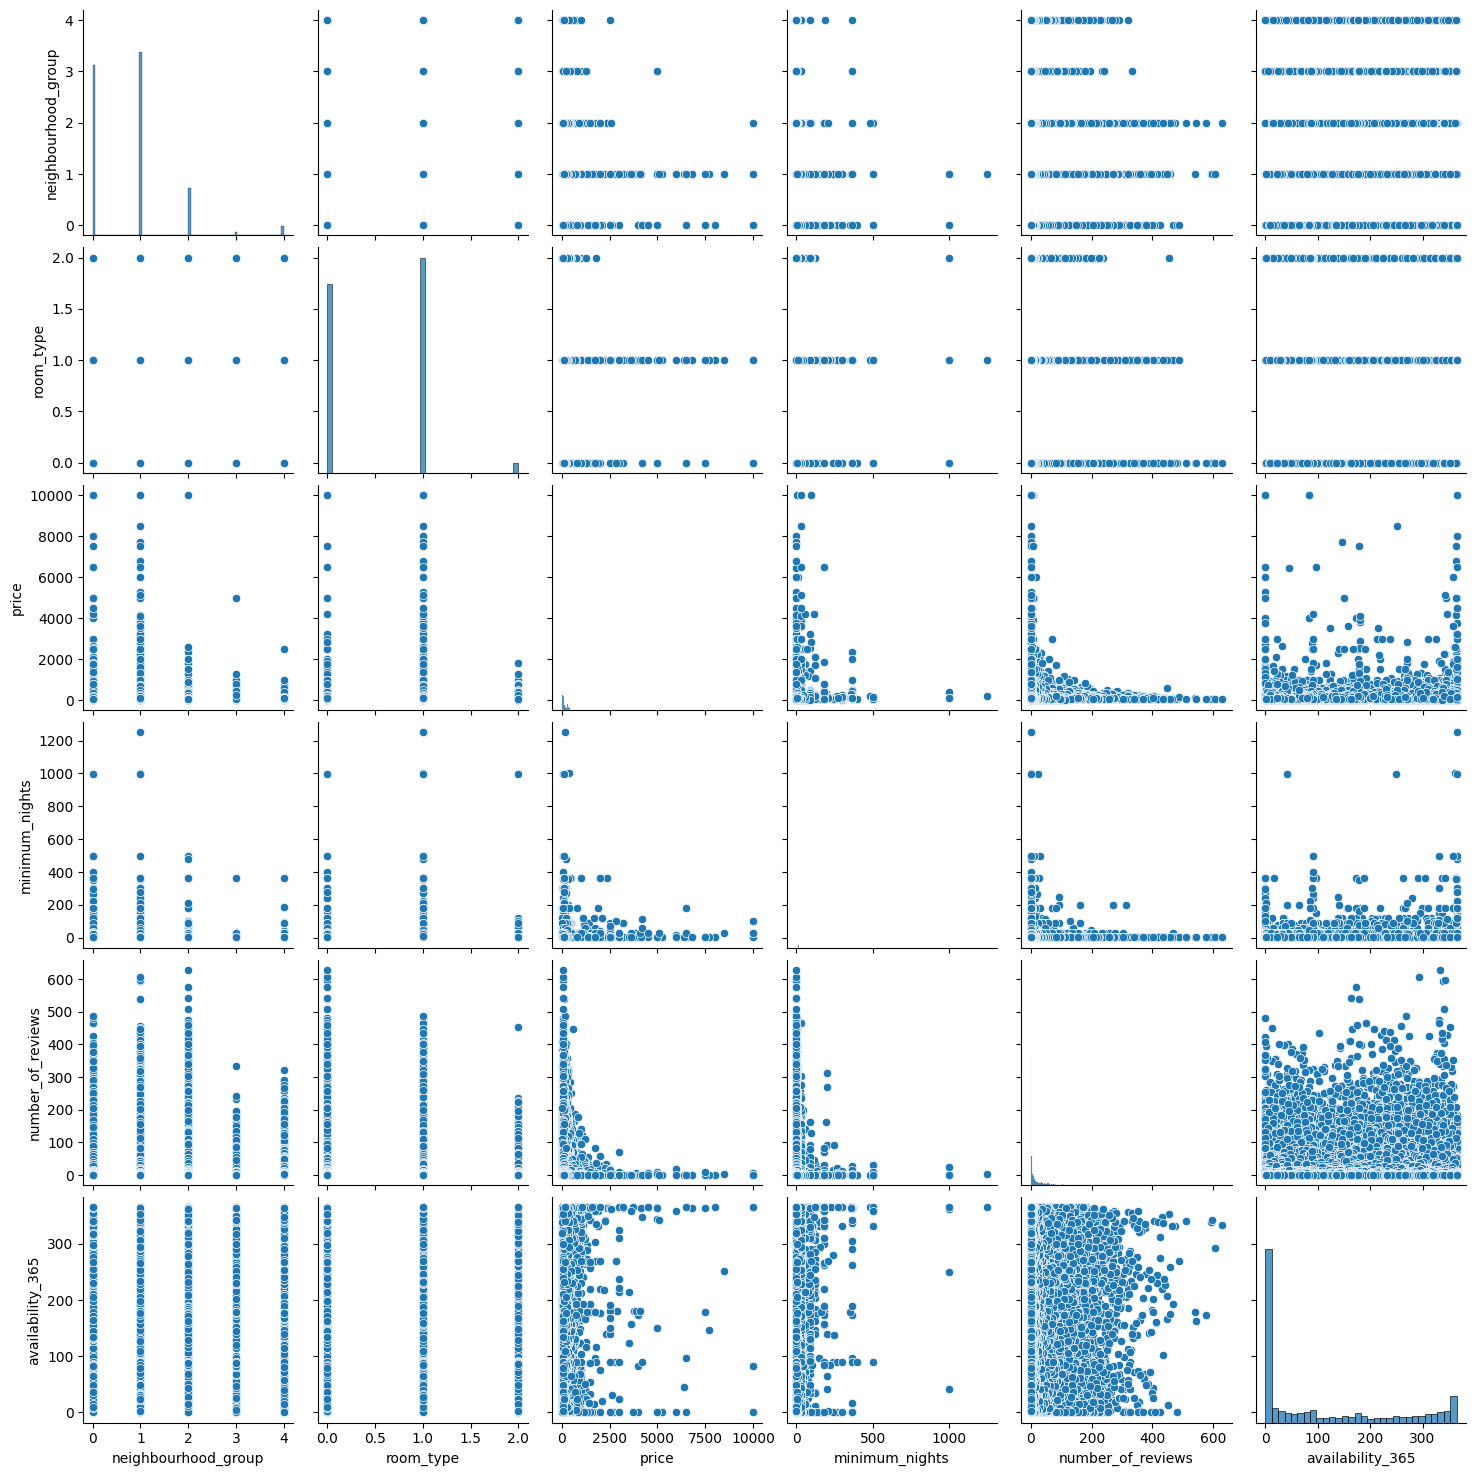

In [37]:
# relaciones todos con todos
sns.pairplot(data = df_new)

## 10. Detectando y trabajando Outliers

In [38]:
df_new.describe()

,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,0.786911,0.567113,152.720687,7.029962,23.274466,112.781327
std,0.844386,0.541249,240.154170,20.510550,44.550582,131.622289
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,69.000000,1.000000,1.000000,0.000000
50%,1.000000,1.000000,106.000000,3.000000,5.000000,45.000000
75%,1.000000,1.000000,175.000000,5.000000,24.000000,227.000000
max,4.000000,2.000000,10000.000000,1250.000000,629.000000,365.000000


In [39]:
# Detectar outliers usando el rango intercuartílico (IQR) y agregar información detallada
outliers_info = {}
for col in variables_numericas:
    Q1 = df_new[col].quantile(0.25)
    Q3 = df_new[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detectar los valores outliers
    outliers = df_new[(df_new[col] < lower_bound) | (df_new[col] > upper_bound)]
    num_outliers = len(outliers)
    
    # Guardar la información en el diccionario
    outliers_info[col] = {
        "num_outliers": num_outliers,
        "lower_bound": lower_bound,
        "upper_bound": upper_bound,
        "outlier_range_below": outliers[col][outliers[col] < lower_bound].tolist(),
        "outlier_range_above": outliers[col][outliers[col] > upper_bound].tolist()
    }
    
    # Mostrar la información resumida para cada variable <3, qué bonito ha quedado
    print(f"Variable: {col}")
    print(f"  Outliers detectados: {num_outliers}")
    print(f"  Límite inferior: {lower_bound:.2f}")
    print(f"  Límite superior: {upper_bound:.2f}")
    print()  # Espacio para separar variables

#outliers_info  # Diccionario con toda la información de los outliers


Variable: neighbourhood_group
  Outliers detectados: 1464
  Límite inferior: -1.50
  Límite superior: 2.50

Variable: room_type
  Outliers detectados: 0
  Límite inferior: -1.50
  Límite superior: 2.50

Variable: price
  Outliers detectados: 2972
  Límite inferior: -90.00
  Límite superior: 334.00

Variable: minimum_nights
  Outliers detectados: 6607
  Límite inferior: -5.00
  Límite superior: 11.00

Variable: number_of_reviews
  Outliers detectados: 6021
  Límite inferior: -33.50
  Límite superior: 58.50

Variable: availability_365
  Outliers detectados: 0
  Límite inferior: -340.50
  Límite superior: 567.50



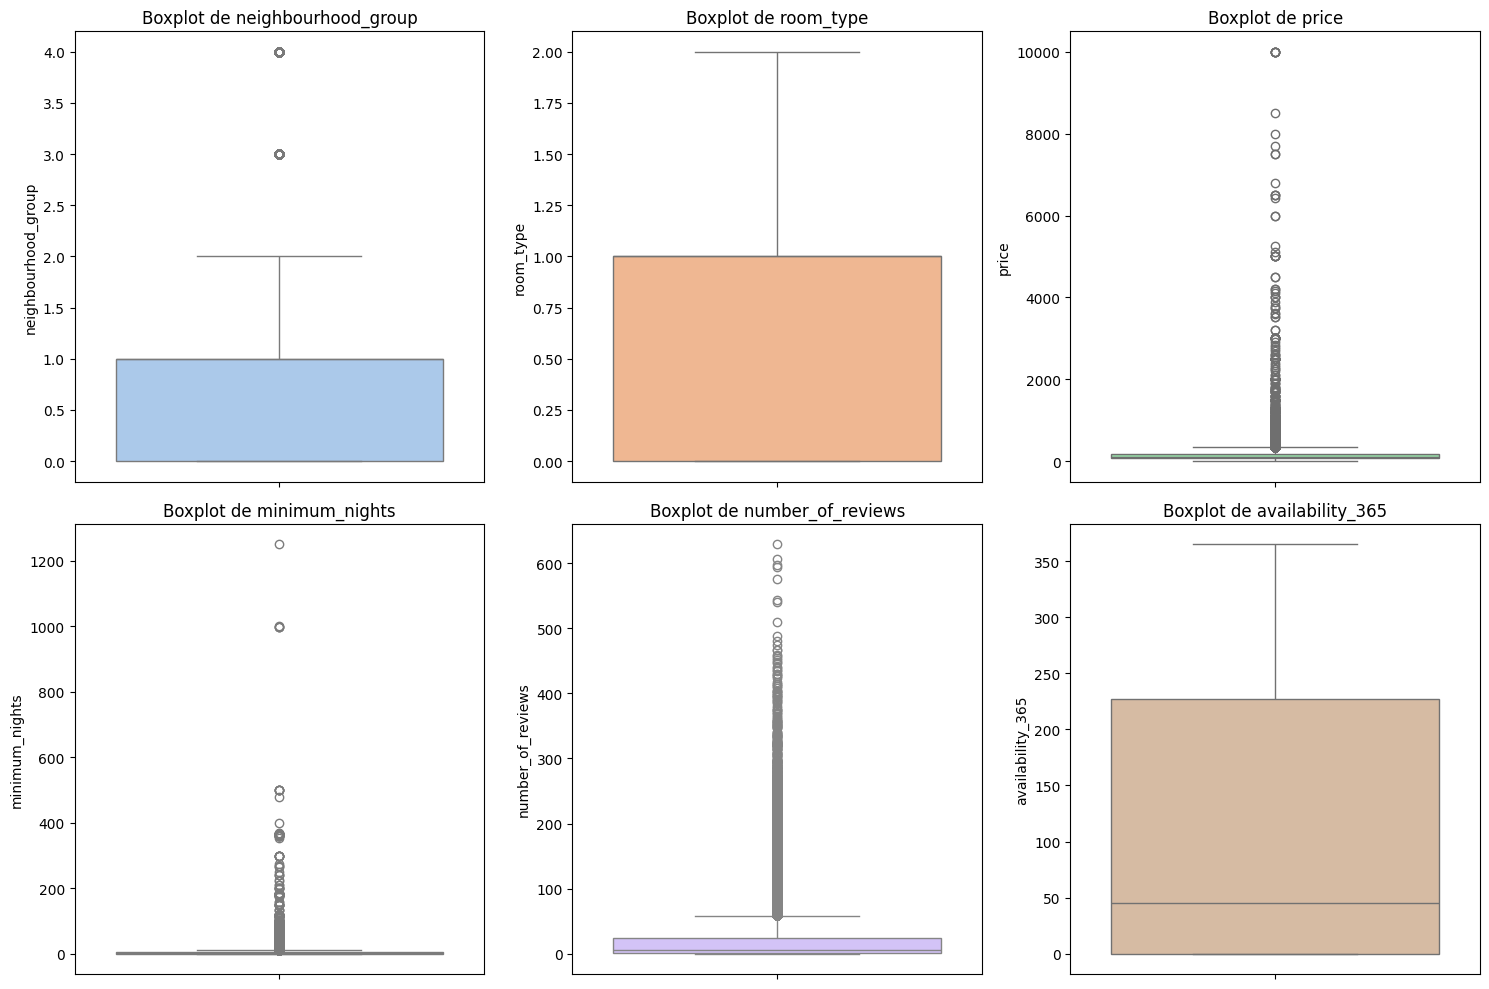

In [40]:
# Lista de colores para los boxplots
colors = sns.color_palette("pastel", len(variables_numericas))

# Configurar el layout de gráficos
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Ajustar según el número de variables

# Iterar sobre las variables numéricas y graficar boxplots
for i, col in enumerate(variables_numericas):
    row, col_index = divmod(i, 3)  # Calcular posición en la cuadrícula
    sns.boxplot(data=df_new, y=col, ax=axes[row, col_index], color=colors[i])
    axes[row, col_index].set_title(f'Boxplot de {col}')
    axes[row, col_index].set_ylabel(col)

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()
plt.show()


In [41]:
df_new.head()

,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,availability_365
0,0,0,149,1,9,365
1,1,1,225,1,45,355
2,1,0,150,3,0,365
3,0,1,89,1,270,194
4,1,1,80,10,9,0


Creamos una copia del data set y uno lo trabajaremos con los outliers moldeados y otro con los datos originales.
Guardaremos los outliers originales en un archivo .json para recurrir a ellos en caso necesario. 

In [42]:
# Ruta para guardar el archivo JSON
json_file_path = './data/outlier_limits.json'

# Crear un diccionario para almacenar los límites de outliers
outlier_limits = {}


# Guardar los límites en un archivo JSON
try:
    with open(json_file_path, 'w') as f:
        json.dump(outlier_limits, f, indent=4)
    print(f"Límites de outliers guardados en: {json_file_path}")
except Exception as e:
    print(f"No se pudo guardar el archivo JSON: {e}")





Límites de outliers guardados en: ./data/outlier_limits.json


In [43]:
# Crear DataFrame sin outliers
df_sin_outliers = df_new.copy()

In [44]:
# Filtrar para eliminar los outliers según los límites calculados
for col in outlier_limits.keys():
    lower_bound = outlier_limits[col]["lower_bound"]
    upper_bound = outlier_limits[col]["upper_bound"]
    df_without_outliers = df_without_outliers[
        (df_sin_outliers[col] >= lower_bound) & (df_sin_outliers[col] <= upper_bound)
    ]

df_original = df_new # cambio el nomntr del df para luego aclararme

# Comparar tamaños
print("Tamaño original:", df_original.shape)
print("Tamaño sin outliers:", df_sin_outliers.shape)

Tamaño original: (48895, 6)
Tamaño sin outliers: (48895, 6)


## División de datos 

Cuando entrenamos modelos de Machine Learning necesitamos:

- Un conjunto de entrenamiento (train) para que el modelo aprenda los patrones de los datos
- Un conjunto de prueba (test) para evaluar el rendimiento del modelo en datos nuevos
  
Por lo general dividimos los datos en 80% para entrenamiento y un 20% para prueba.

#### 1. Identificar las variables predictorias y variable objetivo   
  
- Variable predictoria (x): Columnas que usará el modelo para predecir
- Variable objetivo (y): La que queremos predecir (en este caso 'price')
  
#### 2. Usar train_test_split (división automática en conjuntos de prueba y datos)


In [45]:
x_sin_outliers = df_sin_outliers.drop(columns=['price']) #[aquí pondríamos las variables a trabajar en este caso no porque son todas numericas y trabajamos todas menos la objetiva]  #variable predictoria donde moldearemos outliers
x_original = df_original.drop(columns=['price']) # variable predictoria original
y = df_original['price'] #variable objetiva / esta no se toca 


# División 1: Conjunto original con outliers
x_train_con_outliers, x_test_con_outliers, y_train, y_test= train_test_split(x_original, y, test_size=0.2, random_state=42)

# División 2: Conjunto sin outliers
x_train_sin_outliers, x_test_sin_outliers, y_train, y_test= train_test_split(x_sin_outliers, y, test_size=0.2, random_state=42)

x_train_con_outliers.head()

,neighbourhood_group,room_type,minimum_nights,number_of_reviews,availability_365
32645,0,1,3,11,1
23615,1,0,2,2,0
31183,0,0,2,0,0
29260,0,1,3,87,267
7275,2,0,5,13,0


In [46]:
y_train.head()

32645    295
23615     70
31183     58
29260     75
7275      38
Name: price, dtype: int64

## Implimentar Escalado y normalización

#### ¿Por qué hacer escalado y normalización?
  
- 'price' podría estar en miles, mientras que number_of_reviews puede estar entre 0 y 600.
- Esto puede llevar a que los modelos den más peso a las variables con valores más altos, afectando su rendimiento.
  
Para evitar esto, hacemos escalado o normalización. Esto asegura que todas las variables tengan un rango uniforme, ayudando al modelo a converger mejor y aprender más rápido.

![alt text](image.png)

##### NORMALIZACIÓN (Z-SCORE)

In [47]:
#  Creamos escalador Z-Score 
scaler_norm = StandardScaler()

# Ajustar el escalador a los datos de entrenamiento
scaler_norm.fit(x_train_sin_outliers)

#Transformar los datos de entrenamiento 
x_train_norm = scaler_norm.transform(x_train_sin_outliers)
x_test_norm = scaler_norm.transform(x_test_sin_outliers)

# Convertir resultado en DFs
x_train_norm = pd.DataFrame(x_train_norm, index=x_train_sin_outliers.index, columns=x_train_sin_outliers.columns)
x_test_norm = pd.DataFrame(x_test_norm, index=x_test_sin_outliers.index, columns=x_test_sin_outliers.columns)


# Guardar el escalador
dump(scaler_norm, open("scaler_norm.sav", "wb"))


# Mostrar ejemplos de los datos normalizados
print("Datos normalizados - Entrenamiento:")
print(x_train_norm.head())




Datos normalizados - Entrenamiento:
       neighbourhood_group  room_type  minimum_nights  number_of_reviews  \
32645            -0.931915   0.798949       -0.193025          -0.277198   
23615             0.256169  -1.050482       -0.239596          -0.479451   
31183            -0.931915  -1.050482       -0.239596          -0.524396   
29260            -0.931915   0.798949       -0.193025           1.430714   
7275              1.444253  -1.050482       -0.099884          -0.232253   

       availability_365  
32645         -0.852862  
23615         -0.860447  
31183         -0.860447  
29260          1.164663  
7275          -0.860447  


##### ESCALADO (Min-Max Scaling)



In [48]:
# Crear el escalador Min-Max
scaler_minmax = MinMaxScaler()

# Ajustar el escalador a los datos de entrenamiento sin outliers
scaler_minmax.fit(x_train_sin_outliers)

# Ajustar a datos de entrenamiento
x_train_scaled = scaler_minmax.transform(x_train_sin_outliers)
x_test_scaled = scaler_minmax.transform(x_test_sin_outliers)

# Convertir los resultados a DF
x_train_scaled = pd.DataFrame(x_train_scaled, index=x_train_sin_outliers.index, columns=x_train_sin_outliers.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, index=x_test_sin_outliers.index, columns=x_test_sin_outliers.columns)
#guardar el escalador Min-Max
dump(scaler_minmax, open("scaler_minmax.sav", "wb"))

# Muestra
print("\nDatos escalados Min-Max - Entrenamiento:")
print(x_train_scaled.head())


Datos escalados Min-Max - Entrenamiento:
       neighbourhood_group  room_type  minimum_nights  number_of_reviews  \
32645                 0.00        0.5        0.001601           0.017488   
23615                 0.25        0.0        0.000801           0.003180   
31183                 0.00        0.0        0.000801           0.000000   
29260                 0.00        0.5        0.001601           0.138315   
7275                  0.50        0.0        0.003203           0.020668   

       availability_365  
32645          0.002740  
23615          0.000000  
31183          0.000000  
29260          0.731507  
7275           0.000000  


In [49]:
# Comparar datos normalizados con los originales
print("Datos originales (Sin Outliers):")
print(x_train_sin_outliers.head())

print("\nDatos normalizados (Z-Score):")
print(x_train_norm.head())

print("\nDatos escalados (Min-Max):")
print(x_train_scaled.head())


Datos originales (Sin Outliers):
       neighbourhood_group  room_type  minimum_nights  number_of_reviews  \
32645                    0          1               3                 11   
23615                    1          0               2                  2   
31183                    0          0               2                  0   
29260                    0          1               3                 87   
7275                     2          0               5                 13   

       availability_365  
32645                 1  
23615                 0  
31183                 0  
29260               267  
7275                  0  

Datos normalizados (Z-Score):
       neighbourhood_group  room_type  minimum_nights  number_of_reviews  \
32645            -0.931915   0.798949       -0.193025          -0.277198   
23615             0.256169  -1.050482       -0.239596          -0.479451   
31183            -0.931915  -1.050482       -0.239596          -0.524396   
29260            -0

In [50]:
# Verificar estadísticas básicas
print("Estadísticas de los datos normalizados (Z-Score):")
print(x_train_norm.describe())

print("\nEstadísticas de los datos escalados (Min-Max):")
print(x_train_scaled.describe())


Estadísticas de los datos normalizados (Z-Score):
       neighbourhood_group     room_type  minimum_nights  number_of_reviews  \
count         3.911600e+04  3.911600e+04    3.911600e+04       3.911600e+04   
mean         -6.266930e-18 -7.629306e-17   -1.235221e-17       6.993531e-18   
std           1.000013e+00  1.000013e+00    1.000013e+00       1.000013e+00   
min          -9.319152e-01 -1.050482e+00   -2.861669e-01      -5.243959e-01   
25%          -9.319152e-01 -1.050482e+00   -2.861669e-01      -5.019233e-01   
50%           2.561689e-01  7.989487e-01   -1.930253e-01      -4.120332e-01   
75%           2.561689e-01  7.989487e-01   -9.988379e-02       1.494472e-02   
max           3.820421e+00  2.648379e+00    5.788072e+01       1.361082e+01   

       availability_365  
count      3.911600e+04  
mean      -5.086204e-17  
std        1.000013e+00  
min       -8.604466e-01  
25%       -8.604466e-01  
50%       -5.115514e-01  
75%        8.764447e-01  
max        1.907961e+00  

Est

## ENTRENAMIENTO DEL MODELO - FALLIDO

##### REGRESIÓN LINEAL

In [51]:
# Crear un diccionario para almacenar resultados
resultados = {}

# 1. Modelo en datos originales (con outliers)
lr_con = LinearRegression()
lr_con.fit(x_train_con_outliers, y_train)
y_pred_con = lr_con.predict(x_test_con_outliers)
resultados["Con Outliers"] = {
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_con)),
    "R²": r2_score(y_test, y_pred_con),
}

# 2. Modelo en datos normalizados (Z-Score)
lr_norm = LinearRegression()
lr_norm.fit(x_train_norm, y_train)
y_pred_norm = lr_norm.predict(x_test_norm)
resultados["Normalizado (Z-Score)"] = {
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_norm)),
    "R²": r2_score(y_test, y_pred_norm),
}

# 3. Modelo en datos escalados (Min-Max)
lr_scaled = LinearRegression()
lr_scaled.fit(x_train_scaled, y_train)
y_pred_scaled = lr_scaled.predict(x_test_scaled)
resultados["Escalado (Min-Max)"] = {
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_scaled)),
    "R²": r2_score(y_test, y_pred_scaled),
}

# Mostrar resultados
for conjunto, metricas in resultados.items():
    print(f"\nResultados para {conjunto}:")
    print(f" - RMSE: {metricas['RMSE']:.2f}")
    print(f" - R²: {metricas['R²']:.2f}")



Resultados para Con Outliers:
 - RMSE: 203.31
 - R²: 0.07

Resultados para Normalizado (Z-Score):
 - RMSE: 203.31
 - R²: 0.07

Resultados para Escalado (Min-Max):
 - RMSE: 203.31
 - R²: 0.07


Iba a volver a trabajar las columnas que eliminé pero me rindo, parece que este modelo no funciona con regresión lineal y no es la finalidad del ejercicio ¿verdad? :) FIN DEL EDA  


## GUARDAR DATASETS

In [52]:

# Crear la ruta 
processed_data_path = './data/processed'
os.makedirs(processed_data_path, exist_ok=True)

# Guardar el DataFrame procesado con y sin outliers
df_original.to_csv(os.path.join(processed_data_path, 'data_with_outliers.csv'), index=False)
df_sin_outliers.to_csv(os.path.join(processed_data_path, 'data_without_outliers.csv'), index=False)

print(f"Conjuntos de datos procesados guardados en: {processed_data_path}")


Conjuntos de datos procesados guardados en: ./data/processed
